In [3]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import gc

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


###  Loading and pre-processing the data

In [4]:
train_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/QLKNN_train_data.pkl")

In [3]:
# choosing one input dimension and one output dimension as random
input_dim = #np.random.permutation(list(train_data.iloc[:,:15].columns))
output_dim = #np.random.permutation(list(train_data.iloc[:,15:].columns))

In [4]:
print(f"Input dimension to use: {input_dim[0]} and {input_dim[1]}")
print(f"Input dimension to use: {output_dim[0]}")

Input dimension to use: smag and alpha
Input dimension to use: pfitem_gb_div_efetem_gb


In [5]:
drop_data = train_data[[f'{input_dim[0]}',f'{input_dim[1]}',f'{output_dim[0]}']].dropna()

In [5]:
drop_data = train_data[['smag', 'alpha', 'pfitem_gb_div_efetem_gb']].dropna()

In [6]:
x_train_data = drop_data.iloc[:,:2]
y_train_data = drop_data.iloc[:,2:]

assert x_train_data.shape[0] == y_train_data.shape[0]

In [7]:
n = 100
idx = np.random.permutation(n)

In [8]:
x_train_data = torch.tensor(x_train_data.values)[idx]
y_train_data = torch.tensor(y_train_data.values)[idx]

x_min, x_max = x_train_data.min(), x_train_data.max()

In [9]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, shape):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([shape]))
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(batch_shape=torch.Size([shape])), batch_shape=torch.Size([shape]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [10]:
# initialize likelihood and model
B = 1
YD = 1
likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=torch.Size([B * YD]))
model = ExactGPModel(x_train_data, y_train_data, likelihood, B * YD)

In [11]:
def train_gp_batched_scalar(Zs, Ys, use_cuda=False, epochs=10, lr=0.1):
    """Computes a Gaussian Process object using GPyTorch. Each outcome is
    modeled as a single scalar outcome.
    """
    # Preprocess batch data
    B, N, XD = Zs.shape  # B is batch dimension, N is points dimension, and XD is feature dimension
    #YD = Ys.shape[-1]  # YD is target dimension
    YD = 1
    print(YD)
    
    # Convert features to tensor, and tile according to output targets
    train_x = torch.tensor(Zs)
    train_x = train_x.repeat((YD, 1, 1))
    
    # Convert targets to tensor, and reshape from (B, N, YD) --> (B * YD, N)
    train_y = torch.tensor(Ys)
    train_y = train_y.view(B * YD, N)

    # initialize likelihood and model - batch over output dimensions and batches
    likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=torch.Size([B * YD]))
    model = ExactGPModel(train_x, train_y, likelihood, B * YD)

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    # Define training helper function
    def epoch_train():
        optimizer.zero_grad()  # Zero gradients
        output = model(train_x)  # Compute noise-free output
        loss = -mll(output, train_y).sum()  # Compute batched loss
        loss.backward()  # Compute gradients with backpropagation
        optimizer.step()  # Update weights with gradients
        optimizer.zero_grad()  # Zero gradients
        gc.collect()  # Used to ensure there is no memory leak
    
    # Run training
    for i in range(epochs):
        epoch_train()

    torch.cuda.empty_cache()
    return model, likelihood


In [12]:
y_train_data.shape

torch.Size([100, 1])

In [13]:
# Set parameters
B = 256  # Batch dimension
N = 25   # Number of points
XD = 2   # Dimension of features
YD = 1   # Dimension of targets
EPOCHS = 50
USE_CUDA = False#torch.cuda.is_available()

# Create training data and labels
train_x_np = np.random.normal(loc=0, scale=1, size=(B, N, XD))  # Create as np array
train_y_np = np.random.normal(loc=0, scale=1, size=(B, N, YD))  # Create as np array
x_train_data = x_train_data.reshape(1,-1,2)
y_train_data = y_train_data.reshape(1,-1,1)

#train_x = torch.tensor(train_x_np).float()  # Can use .double() for 64-bit fp precision
#train_y = torch.tensor(train_y_np).float()  # Can use .double() for 64-bit fp precision
#train_x = torch.tensor(x_train_data).float()  # Can use .double() for 64-bit fp precision
#train_y = torch.tensor(x_train_data).float()  # Can use .double() for 64-bit fp precision

# Time GPyTorch training
model, likelihood = train_gp_batched_scalar(x_train_data, y_train_data,
                        use_cuda=USE_CUDA, epochs=EPOCHS, lr=0.1)

# Calling .eval() places the model and likelihood in "posterior" mode
model.eval()
likelihood.eval()

# Define mll
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

1


/tmp/ipykernel_16740/481347191.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x = torch.tensor(Zs)
/tmp/ipykernel_16740/481347191.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(Ys)


In [14]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    testx1 = np.linspace(x_min, x_max , 50)
    testx2 =  np.linspace(x_min, x_max , 50)
    
    test_x = torch.tensor(np.array(np.meshgrid(testx1, testx2)).T.reshape(-1,2), dtype = torch.double)
    
    print(x_train_data.shape)
    print(test_x.shape)
    
    observed_pred = likelihood(model(test_x))
    mean = observed_pred.mean
    variance = observed_pred.variance

torch.Size([1, 100, 2])
torch.Size([2500, 2])


tensor([[ 4.4088e+00,  4.8244e+00,  4.9554e-01,  4.5769e-01,  1.2063e+00,
          2.5803e+00,  7.0734e-01,  2.7328e-01,  1.2067e+00,  1.1553e+00,
          2.9661e+00,  1.5930e+00,  7.1768e-01,  2.5191e+00,  2.5764e+00,
          8.8613e-01,  8.0657e-01,  3.3582e+00,  1.2624e-01,  6.4287e+00,
          1.1884e-01, -7.1203e-04,  4.1987e+00,  8.5719e-01,  2.9929e+00,
          1.4350e+00,  3.6410e+00, -4.1548e-01,  2.1160e+00,  5.3527e+00,
          2.8863e+00,  4.0418e+00,  3.0573e+00,  2.6655e-01,  1.0353e+00,
          1.1767e+00,  5.7402e-01,  2.0996e+00,  1.5254e-01,  1.4062e+00,
          2.1257e+00,  2.0477e+00,  1.0466e+00,  1.9527e+00,  3.7448e-01,
          2.7767e+00,  2.6052e+00,  3.0377e+00,  1.2372e+00,  2.0594e+00,
          1.9820e+00,  1.1140e+00,  1.5590e-01,  9.6585e-01,  6.5286e-01,
         -4.5490e-01,  2.1665e-01,  2.0455e+00,  8.3074e-01,  8.7509e-01,
          6.3428e-01,  1.4923e+00,  3.3675e-01,  4.5280e-01,  1.3022e-01,
          1.8706e+00,  4.3130e-01,  2.

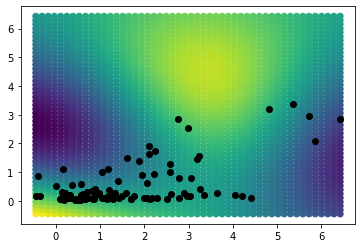

In [25]:

output = mean.cpu().detach().numpy()
out_y = np.squeeze(output)

# Reformat, get analytic y, and plot
x_plot = np.squeeze(test_x)

plt.scatter(x_plot[:,0], x_plot[:, 1], c = out_y)
plt.scatter(x_train_data[:,:,0].squeeze(), x_train_data[:,:,1].squeeze(), c='black')
#plt.title("Test X vs. Predicted Y, Dimension {}".format(DIM))
plt.show()

# Creating color map
my_cmap_analytic = plt.get_cmap('hot')
my_cmap_predicted = plt.get_cmap('cool')

# Plot ground truth
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_trisurf(x_plot[..., 0], x_plot[..., 1], y_plot_gt[..., DIM],
#                antialiased=True, cmap=my_cmap_analytic)
#plt.title("Analytic, Ground Truth Surface, Dimension {}".format(DIM))
#plt.show()

# Plot the predicted values
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_trisurf(x_plot[..., 0], x_plot[..., 1], out_y[..., DIM],
#                antialiased=True, cmap=my_cmap_predicted)
#plt.title("Predicted Surface, Dimension {}".format(DIM))
#plt.show()

In [29]:

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_train_data)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train_data).mean()
    loss.backward()
    
    lenlist = model.covar_module.base_kernel.lengthscale.tolist()[0]
    
    noise = model.likelihood.noise.item()
    
    #lengthscales = [f'{lenlist[0]:.3f}', f'{lenlist[1]:.3f}']
    
    #print(f'Iter {(i+1)/training_iter} - Loss: {loss.item():.3f} lengthscales:{lengthscales} noise: {noise:.4f} ')
    
    optimizer.step()

RuntimeError: Expected object of scalar type float but got scalar type double for argument 'other'

In [20]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    testx1 = np.linspace(x_min, x_max , 50)
    testx2 =  np.linspace(x_min, x_max , 50)
    
    test_x = torch.tensor(np.array(np.meshgrid(testx1, testx2)).T.reshape(-1,2), dtype = torch.double)
    
    print(x_train_data.shape)
    print(test_x.shape)
    
    observed_pred = likelihood(model(test_x))

torch.Size([100, 2])
torch.Size([2500, 2])


RuntimeError: shape '[100, 100]' is invalid for input of size 100

ValueError: 'x' is not 1-dimensional

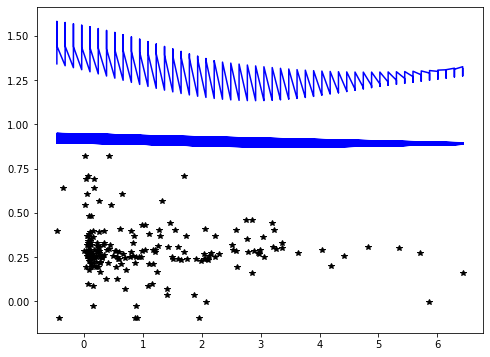

In [38]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(x_train_data.squeeze().numpy(), y_train_data.squeeze().numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x, torch.transpose(observed_pred.mean, 0, 1).numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
#     ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])